This is a starter file of network simulation

## Set file path of mask and illumination profile

In [1]:
mask_filepath='./private_data/Mask_profile_20181016.png'
illumination_filepath='./private_data/Illumination_profile_20181016.png'

## Import the required packages

In [2]:
import numpy as np
import os
import copy
import matplotlib.pyplot as plt

from skimage.io import imread

from solcore.structure import Junction
from solcore.solar_cell import SolarCell
from solcore.light_source import LightSource
from spice.dynamic_pixel import solve_quasi_3D
from spice.dynamic_pixel import get_merged_r_image
from spice.fom import ff


	Welcome to Solcore - version 5.5.2
	Copyright (c) 2018, Imperial College London. All rights reserved.
	Software released under the GNU Lesser General Public License.

No module named 'solcore.poisson_drift_diffusion.ddModel'


In [3]:
save_data_path="./tmp_out/"
def to_data_path(filename):
    return os.path.join(save_data_path,filename)

## Load the pattern of the contact

In [4]:
contactsMask = imread(mask_filepath)
contactsMask=contactsMask[:,:,0]

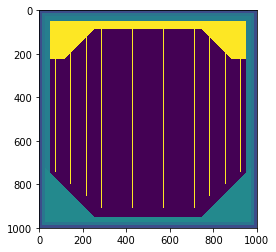

In [5]:
plt.imshow(contactsMask)

## Reduce the shape to 1/2 because of symmetry

In [6]:
nx, ny = contactsMask.shape
contactsMask = contactsMask[:, int(ny / 2):]

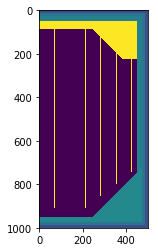

In [7]:
plt.imshow(contactsMask)

## Make illumination

Load the illumination profile. The file can be either a PNG file or a comma sepearted file.

In [8]:
# both csv and png file are supported.
image_file=illumination_filepath
#image_file=join(this_path,"Illumination profile_20180926_random.csv")

In [9]:
def load_illumination(fname):
    _,ext=os.path.splitext(fname)
    ext=ext[1:].lower()
    if (ext=='png'):
        img=imread(fname)
        if img.ndim==3:
            img=img[:,:,0]
    elif (ext=='csv'):
        img=np.loadtxt(fname,delimiter=',')
    return img

In [10]:
img=load_illumination(image_file)

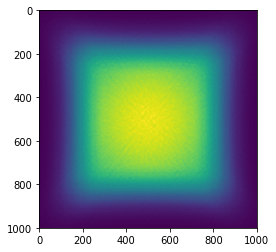

In [11]:
plt.imshow(img)

### Show statistics of the profile

Show histogram of pixel values

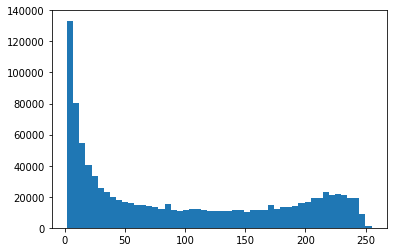

In [12]:
plt.hist(img.ravel(),bins=50)
plt.show()

Total of the pixel value:

In [13]:
value_sum=np.sum(img)
print("The sum of total pixel value: {}".format(value_sum))

The sum of total pixel value: 95974375


In [14]:
pixel_photon_unit=1.1426e11
print("The sum of photon number: {}".format(value_sum*pixel_photon_unit))

The sum of photon number: 1.09660320875e+19


### Reduce the shape to 1/2

In [15]:
illuminationMask=img
illuminationMask=illuminationMask[:, int(img.shape[1] / 2):]

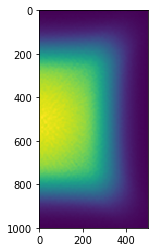

In [16]:
plt.imshow(illuminationMask)

In [17]:
np.max(illuminationMask)

254

In [18]:
illuminationMask.shape

(1000, 500)

## Set solar cell parameters

In [19]:
# Size of the pixels (m)
Lx = 1e-6
Ly = 1e-6

# Height of the metal fingers (m)
h = 2.2e-6

# Contact resistance (Ohm m2)
Rcontact = 3e-10

# Resistivity metal fingers (Ohm m)
Rline = 2e-8

# Bias (V)
vini = 0
vfin = 3
step = 0.01

T = 298

## Set the parameter of solar cells

This solar cell solver calculates the saturation current J01 and J02 from detail balanced model (assuming 100% aborptivity). Sheet resistance is assigned by the user.

In [20]:
# the solar cell parameters
ge_cell = Junction(kind='2D', T=T, reff=1, jref=300, Eg=0.66, A=1, R_sheet_top=100, R_sheet_bot=1e-16,
                       R_shunt=1e16, n=3.5)
gaas_cell = Junction(kind='2D', T=T, reff=1, jref=300, Eg=1.4, A=1, R_sheet_top=100, R_sheet_bot=1e-16,
                        R_shunt=1e16, n=3.5)
ingap_cell = Junction(kind='2D', T=T, reff=0.5, jref=300, Eg=1.8, A=1, R_sheet_top=100, R_sheet_bot=100,
                        R_shunt=1e16, n=3.5)

# assign which solar cell to use. For example, to use top cell, set my_solar_cell like this:
# my_solar_cell=SolarCell([ingap_cell],T=T)
# For full 3J solar cell, the parameter is like this:
# my_solar_cell=SolarCell([ingap_cell,gaas_cell,ge_cell],T=T)
my_solar_cell = SolarCell(copy.deepcopy([ingap_cell,gaas_cell]), T=T)

### Set the light source

In [21]:
wl = np.linspace(350, 2000, 301) * 1e-9
light_source = LightSource(source_type='standard', version='AM1.5g', x=wl, output_units='photon_flux_per_m',
                           concentration=100)

options = {'light_iv': True, 'wavelength': wl, 'light_source': light_source}

In [22]:
illuminationMask.shape

(1000, 500)

In [23]:
contactsMask.shape

(1000, 500)

### Launch the solver

In [24]:
pw=50
V, I ,Vall, Vmet= solve_quasi_3D(my_solar_cell, illuminationMask, contactsMask, options=options, Lx=Lx,
                                      Ly=Ly,
                                      h=h,
                                      R_back=1e-16, R_contact=Rcontact, R_line=Rline, bias_start=vini,
                                      bias_end=vfin,
                                      bias_step=step, sub_cw=pw, sub_rw=pw)

# Since we model 1/4 of the device, we multiply the current by 4
I = I * 2

Solving 1D Solar Cell...
Solving optics of the solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
... Done!

Solving quasi-3D Solar Cell...
number of data:301
... Done!!


### Voltage map

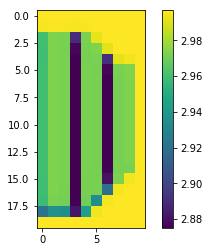

In [25]:
plt.imshow(Vmet[:,:,-1])
plt.colorbar()

### Downsampled image

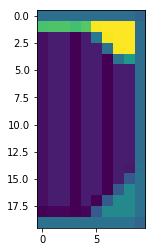

In [26]:
r_image=get_merged_r_image(contactsMask,pw,pw)
plt.imshow(r_image)

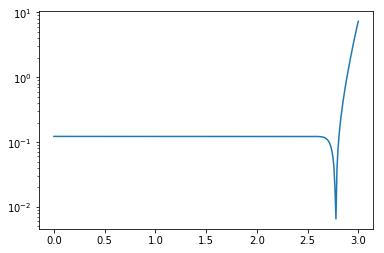

In [27]:
plt.semilogy(V, abs(I))
plt.show()

## Plot in linear scale

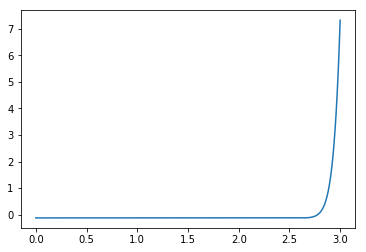

In [28]:
plt.plot(V, I)

Zoom in to negative current

(-0.1343592894777693, 0)

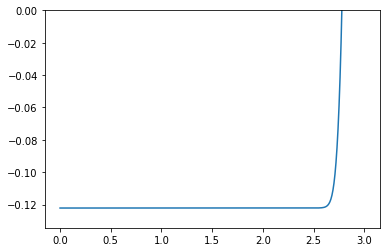

In [29]:
plt.plot(V, I)
plt.ylim([np.min(I)*1.1,0])

## Export the I-V characteristics into a CSV file

The result is written into the file ```iv_result.csv```

In [30]:
output_iv=np.vstack([V,I]).T
np.savetxt(to_data_path('iv_result.csv'),output_iv,delimiter=',')

## Compare simulation with different grid sizes

In [31]:
test_pws=[50,25,10]
file_prefix="3j_pana_"

Wall time: 0 ns
Solving 1D Solar Cell...
Solving optics of the solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
... Done!

Solving quasi-3D Solar Cell...
number of data:301
... Done!!
Solving 1D Solar Cell...
Solving optics of the solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
... Done!

Solving quasi-3D Solar Cell...
number of data:301
... Done!!
Solving 1D Solar Cell...
Solving optics of the solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
... Done!

Solving quasi-3D Solar Cell...
number of data:301
... Done!!


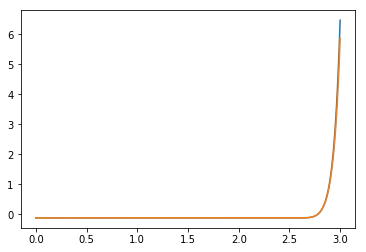

In [32]:
%time
result_vi=None
for pw in test_pws:
    my_solar_cell = SolarCell(copy.deepcopy([ingap_cell,gaas_cell]), T=T)
    V, I ,Vall, Vmet= solve_quasi_3D(my_solar_cell, illuminationMask, contactsMask, options=options, Lx=Lx,
                                      Ly=Ly,
                                      h=h,
                                      R_back=1e-16, R_contact=Rcontact, R_line=Rline, bias_start=vini,
                                      bias_end=vfin,
                                      bias_step=step, sub_cw=pw, sub_rw=pw)

    # Since we model 1/4 of the device, we multiply the current by 4
    I = I * 2
    np.save(to_data_path("{}_vmap_{}.npy".format(file_prefix, pw)), Vmet[:, :, -1])

    if result_vi is None:
        result_vi = np.stack((V, I))
    else:
        result_vi = np.vstack((result_vi, V, I))
        plt.plot(V, I, label="pw: {}".format(pw))

In [33]:
np.savetxt(to_data_path("{}_3j_iv.csv".format(file_prefix)), result_vi.T,
                   delimiter=',')

plt.savefig(to_data_path("{}_1jfig.png".format(file_prefix)))

<Figure size 432x288 with 0 Axes>

fill factor of pw 50: 0.9373
fill factor of pw 25: 0.9370
fill factor of pw 10: 0.9368


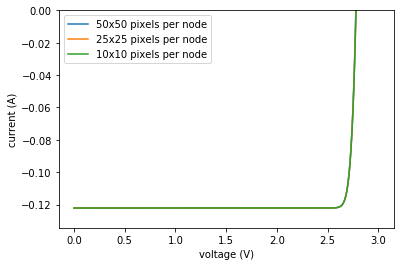

In [35]:
iv=np.loadtxt(to_data_path("{}_3j_iv.csv").format(file_prefix),delimiter=',')
for i in range(0,iv.shape[1],2):
    plt.plot(iv[:,i],iv[:,i+1],label="{0}x{0} pixels per node".format(test_pws[i//2]))
    iv_ff=ff(iv[:,i],iv[:,i+1])
    print("fill factor of pw {}: {:.4f}".format(test_pws[i//2],iv_ff))
plt.ylim((np.min(iv[:,1])*1.1,0))
plt.xlabel("voltage (V)")
plt.ylabel("current (A)")
plt.legend()
plt.savefig(to_data_path("iv_fig.png"),dpi=300)

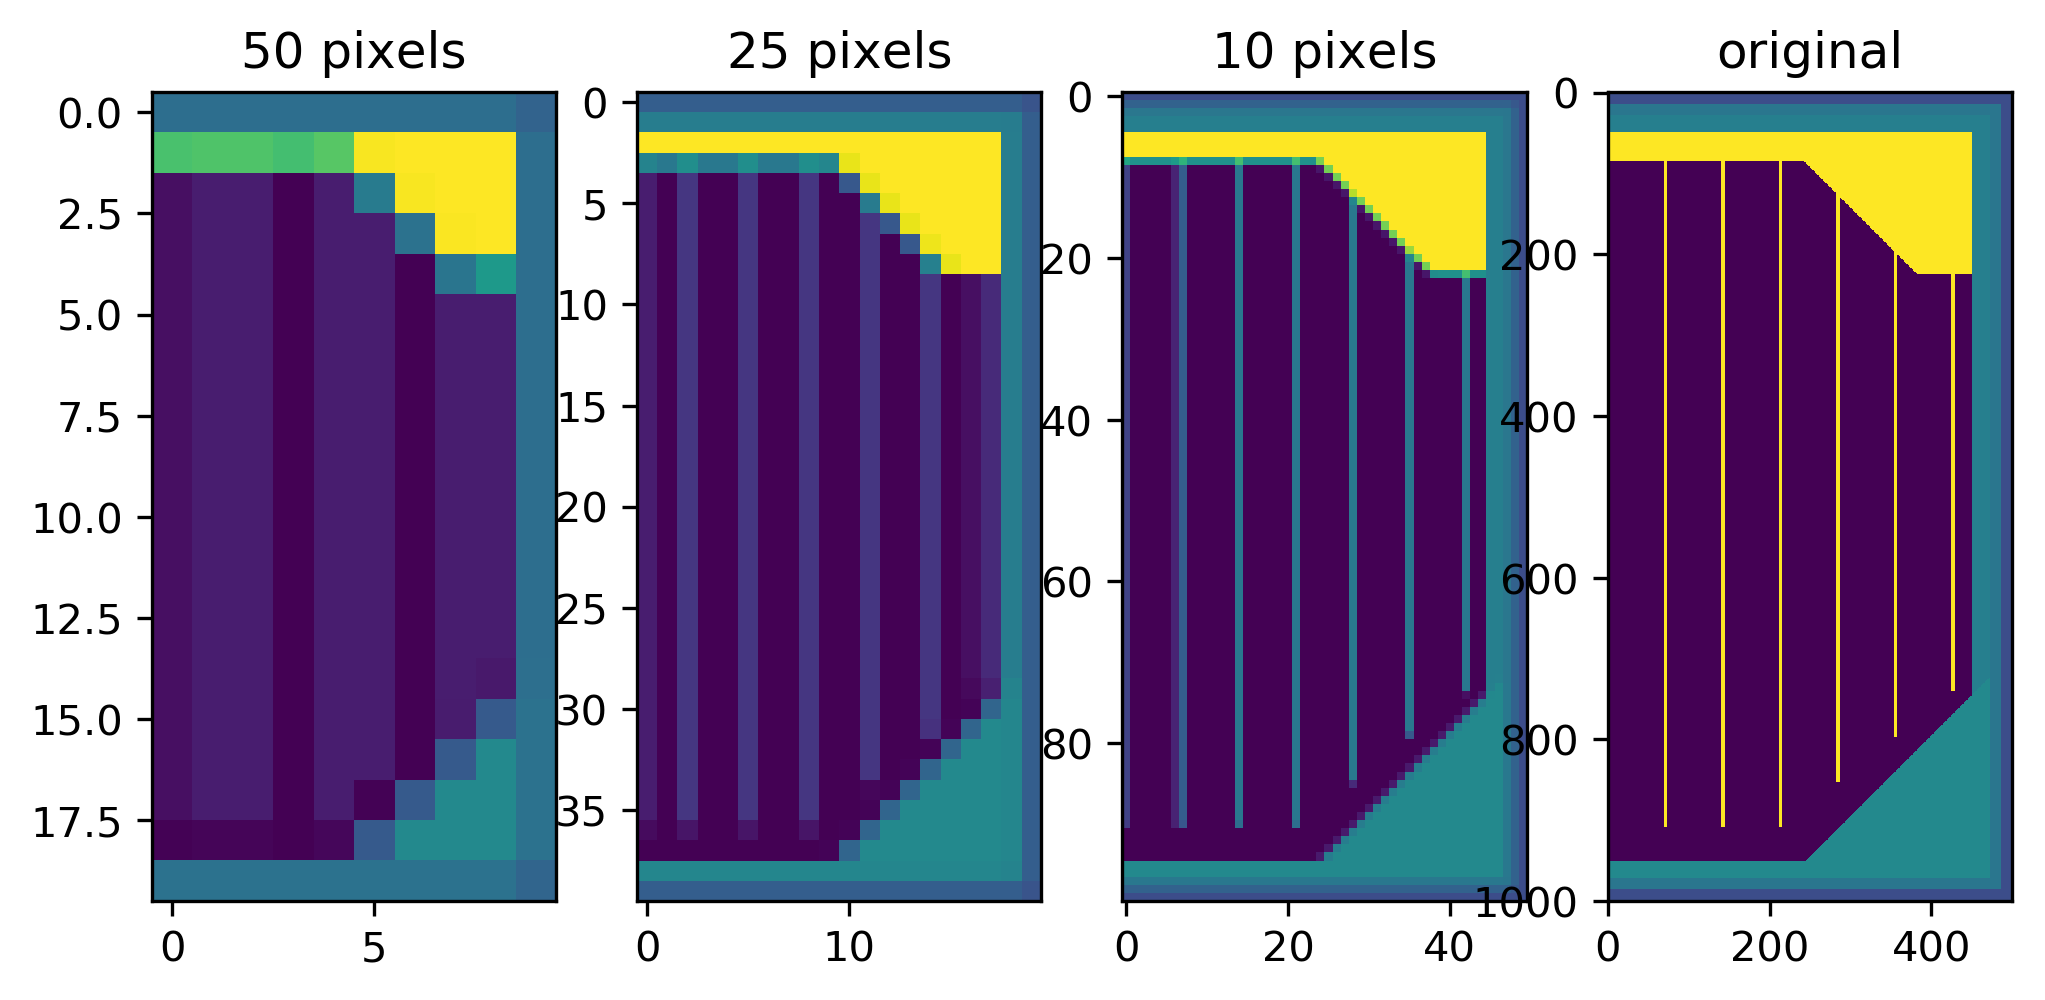

In [36]:
fig,ax=plt.subplots(ncols=len(test_pws)+1,figsize=(8,6),dpi=300)
for i, pw in enumerate(test_pws): 
    r_image=get_merged_r_image(contactsMask,pw,pw)
    ax[i].imshow(r_image)
    ax[i].set_title("{} pixels".format(pw))
r_image=get_merged_r_image(contactsMask,1,1)
ax[-1].imshow(r_image)
ax[-1].set_title("original")
fig.savefig(to_data_path("equiv_r_images.png"))

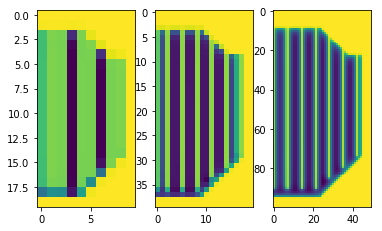

In [38]:
fig,ax=plt.subplots(ncols=len(test_pws))
for i, pw in enumerate(test_pws):
    vmap=np.load(to_data_path('{}_vmap_{}.npy').format(file_prefix,pw))
    ax[i].imshow(vmap)